In [1]:
# Import required dependencies
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import copy
import numpy as np
from datetime import datetime
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from transformers import BertForSequenceClassification, AutoTokenizer, pipeline, BertTokenizer

2024-12-13 09:31:55.416610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 09:31:55.952522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Enabling memory growth on the GPU to prevent TensorFlow from allocating all memory at once
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


In [3]:
class getDataset:
    # Initialize the class with the directory containing the dataset
    def __init__(self, data_dir):
        self.data_dir = data_dir  # Store the directory path
        # Create a list of files in the directory that are actual files (not directories)
        self.file_list = [
            file for file in os.listdir(data_dir)
            if os.path.isfile(os.path.join(data_dir, file))
        ]

    # Return the number of files in the directory
    def __len__(self):
        return len(self.file_list)

    # Retrieve the data from a file given its index in the file list
    def __getitem__(self, idx):
        # Construct the full path to the file
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        
        # Open the file in read mode with UTF-8 encoding
        with open(file_path, 'r', encoding='utf-8') as file:
            raw_data = file.read()  # Read the content of the file

        # Split the content into text data and time data using " : " as a delimiter
        text_data = raw_data.split(" : ")[-1] 
        time_data = raw_data.split(" : ")[0]  

        # Return the text data and time data as a tuple
        return text_data, time_data


In [4]:
dataset = getDataset('./nab')
text_data_array = []

In [5]:
text_data, time_data = dataset.__getitem__(7)

In [6]:
time_data

'2020-06-19T13:02:00+10:00'

In [7]:
text_data

'time will tell.But your prediction every other week "of it will be back down" just hasn\'t happened.Has it dropped under $17 since the SPP, it might have, I haven\'t noticed.'

In [8]:
text_data_array = []
time_data_array = []

In [9]:
# Store the Dataset
for i in range(len(dataset)):
    text_data, time_data = dataset.__getitem__(i)
    text_data_array.append(text_data)
    time_data_array.append(time_data)

text_data_array = np.array(text_data_array)
time_data_array = np.array(time_data_array)

In [10]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and pad/truncate the data
def tokenize_data(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        # Ensure all sequences are of max_len
        padding='max_length',  
        max_length=max_len,
        return_tensors='tf'
    )
    return encodings

max_len = 128
encodings = tokenize_data(text_data_array, tokenizer, max_len=max_len)

2024-12-13 09:32:37.864973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11541 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2024-12-13 09:32:37.865556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11541 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2024-12-13 09:32:37.866035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11541 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2024-12-13 09:32:37.866548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11533 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, comp

In [11]:
# BERT Model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define the model
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output.last_hidden_state

bert_model.trainable = True  # Ensure BERT layers are trainable

# Optionally freeze the pooler layer
for layer in bert_model.layers:
    if 'pooler' in layer.name:
        layer.trainable = False

# CNN layers
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(sequence_output)
pool1 = GlobalMaxPooling1D()(conv1)

# Fully connected layer
fc = Dense(128, activation='relu')(pool1)
dropout = Dropout(0.3)(fc)
output = Dense(1, activation='sigmoid')(dropout)

# Compile model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights("bert_cnn_sentiment_model.h5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [12]:
positive_score = []
negative_score = []
sentiment_datetime = []

# Batch size for processing (adjust this based on your GPU memory)
batch_size = 32

# Process the texts in smaller batches to reduce memory consumption
for start_idx in range(0, len(text_data_array), batch_size):
    end_idx = min(start_idx + batch_size, len(text_data_array))
    print(f"Processing {start_idx}", end="\r", flush=True)
    batch_texts = text_data_array[start_idx:end_idx]
    
    # Tokenize the batch of text data using the BERT tokenizer
    encodings = tokenize_data(batch_texts, tokenizer, max_len=128)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    
    # Predict sentiment using the BERT-CNN model (disable training mode for inference)
    with tf.GradientTape() as tape:
        predictions = model([input_ids, attention_mask], training=False)
    
    # Ensure predictions and time data match
    for pred, td in zip(predictions.numpy(), time_data_array[start_idx:end_idx]):  # Use time_data_array
        if len(pred) == 1:  # For binary classification (positive or negative)
            if pred > 0.4:
                positive_score.append(float(pred))  # Ensure this is a float
                negative_score.append(0)
            else:
                positive_score.append(0)
                negative_score.append(float(abs(1 - pred)))  # Ensure this is a float

        
        sentiment_datetime.append(td)



2024-12-13 09:32:43.230107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
/tmp/ipykernel_1520554/3511558752.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  negative_score.append(float(abs(1 - pred)))  # Ensure this is a float
/tmp/ipykernel_1520554/3511558752.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  positive_score.append(float(pred))  # Ensure this is a float


In [13]:
print(len(positive_score), len(negative_score), len(sentiment_datetime))


16974 16974 16974


In [14]:
# Create a panda dataframe
df = pd.DataFrame({
    'Datetime': sentiment_datetime,
    'positive': positive_score,
    'negative': negative_score,

})
# Set index to the date time
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
df['positive'] = pd.to_numeric(df['positive'], errors='coerce')
df['negative'] = pd.to_numeric(df['negative'], errors='coerce')


# Sort all rows by the datetimeindex
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

In [15]:
# Calculating a 'score' using the positive and negative predictions
df['score'] = (df['positive'] - df['negative'])/(df['positive'] + df['negative'])

# Calculating median sentiment for everyday
df_daily = df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count of the number of entries per day
df_daily_count = df.resample('D').size()

df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

In [16]:
stock_name = "NAB"

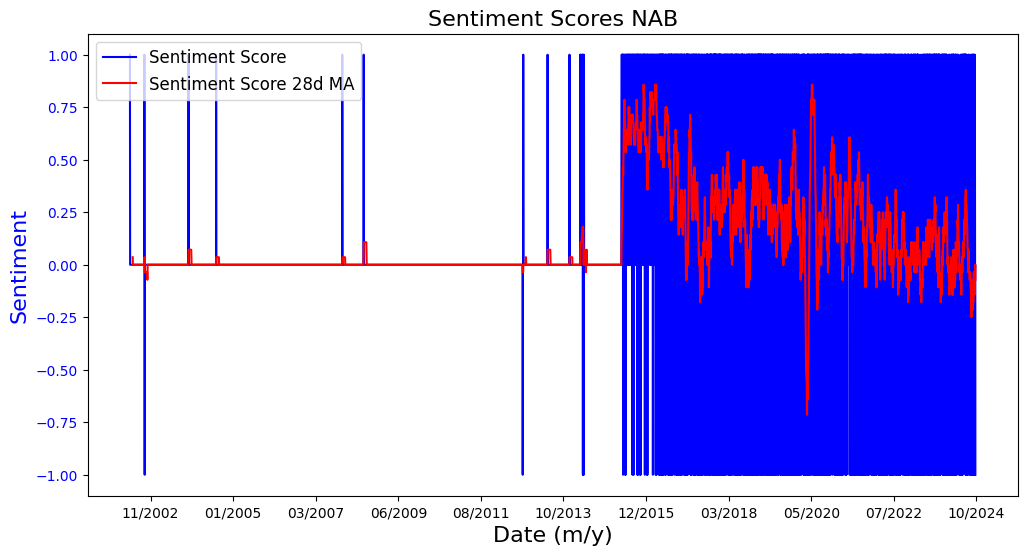

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index, 
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index, 
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores ' + stock_name, fontsize=16)

In [19]:
# Download the stock price data to compare
msft = yf.Ticker(stock_name + ".ax")
stock_data = msft.history(period = "10y", interval = "1d")
stock_data.drop('Dividends', axis=1, inplace=True)
stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends etc)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends etc)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28 day and 120 day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()
stock_data.dropna(inplace=True)

# Calculate the short term price movements by subtracting the 120 day MA
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

/tmp/ipykernel_1520554/1552237004.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [20]:
# Cut the sentiment data to match the same time period as the stock price data
specific_date = stock_data.index[0]

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

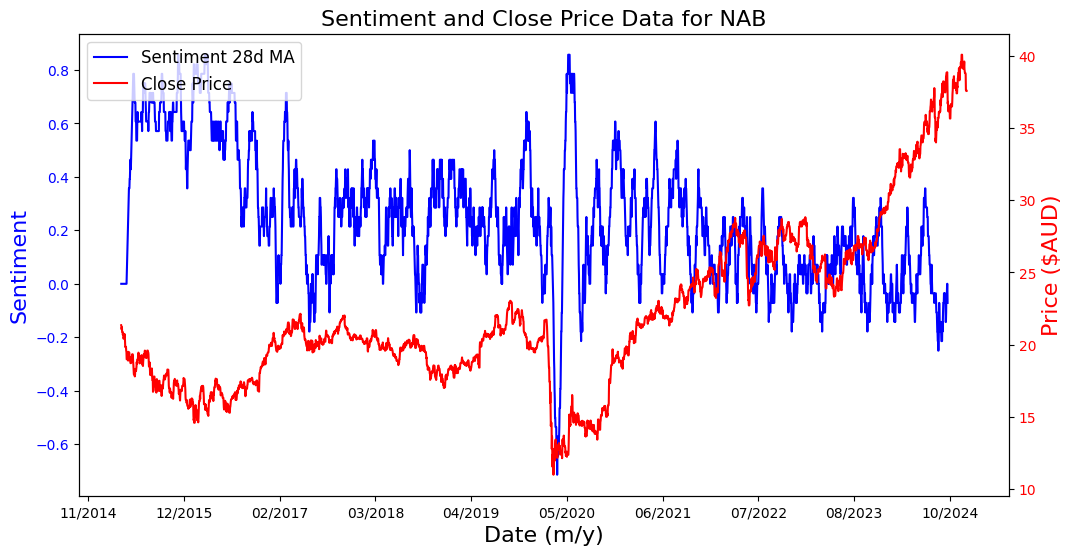

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'], 
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + stock_name.upper(), fontsize=16)

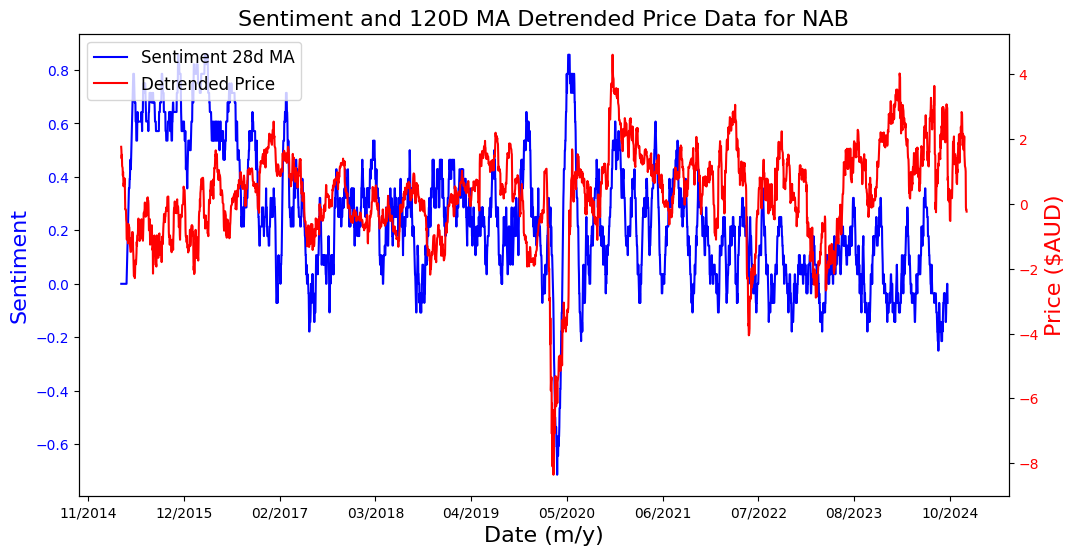

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'], 
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + stock_name.upper(), fontsize=16)

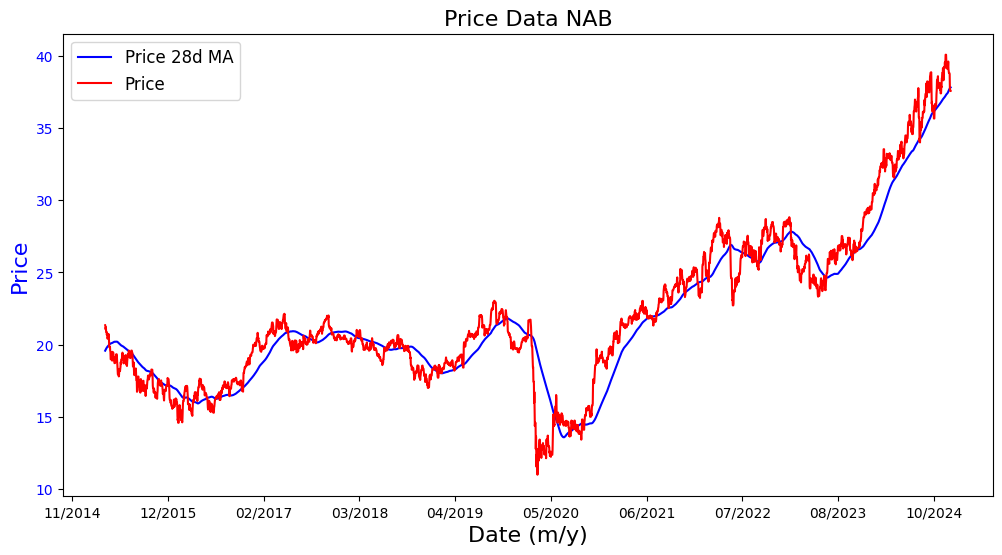

In [26]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index, 
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index, 
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + stock_name.upper(), fontsize=16)

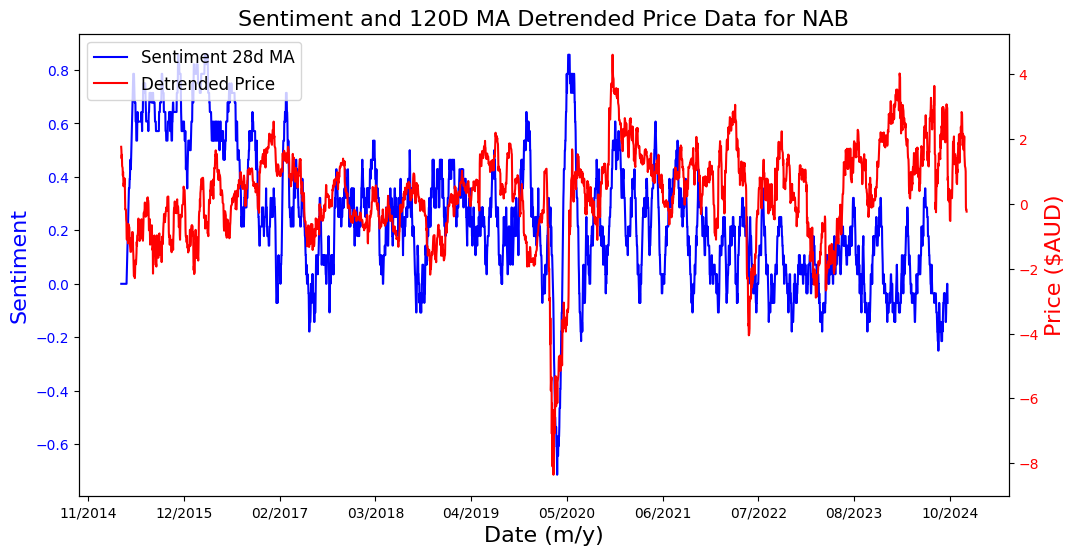

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'], 
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + stock_name.upper(), fontsize=16)

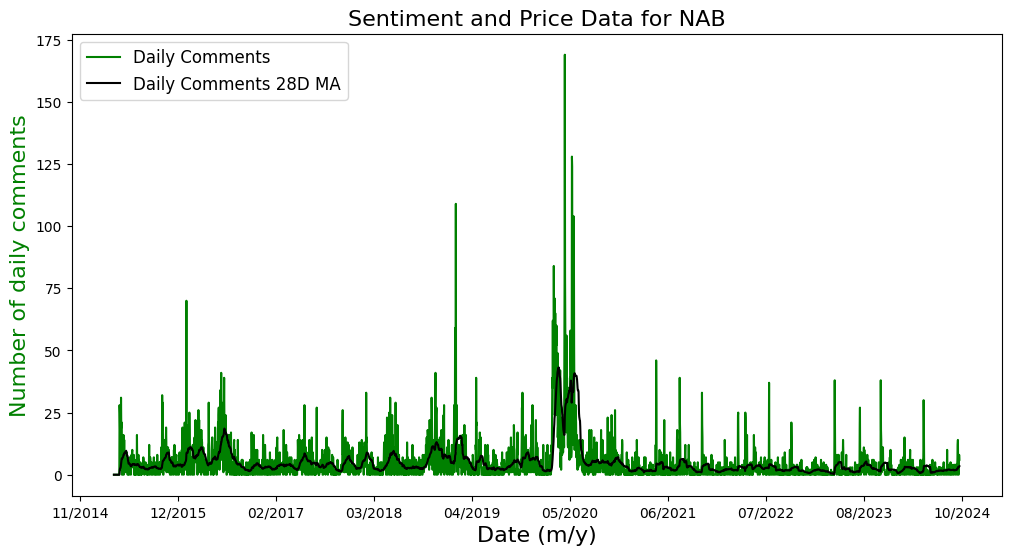

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + stock_name.upper(), fontsize=16)